In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import warnings
warnings.filterwarnings('ignore')
from matplotlib.colors import ListedColormap
from tqdm import tqdm_notebook
from datetime import datetime
from collections import Counter
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

topics = ['face mask', 'hand sanitizer', 'medical supplies', 'test kits',
          'flu', 'common cold', 'social distancing', 'shelter in place',
          'school closure', 'travel ban']           

groupings = {
            'Medical Supplies':['medical supplies','test kits'],
            'PPE':['face mask','hand sanitizer'],
            'Guidelines':['social distancing', 'shelter in place'],
            'Restrictions':['school closure', 'travel ban'],
            'Seasonal Flu':['flu', 'common cold']
             }

themes = ['medical supplies','ppe','recommendations','restrictions','seasonal flu']

__author__ = 'Haomin Lin'
__version__ = 'Python3'

In [2]:
# Read informatin from different platforms
print ("Reading News...")
info_news = pd.read_csv("../../Data/Fusion/news.csv")
info_news = info_news[info_news['length']>100]
info_news['date'] = [datetime.strftime(pd.to_datetime(date), '%Y-%m-%d') for date in tqdm_notebook(info_news['date'])]

print ("Reading Blogs...")
info_blog = pd.read_csv("../../Data/Fusion/blogs.csv")
info_blog = info_blog[info_blog['length']>100]
info_blog['date'] = [datetime.strftime(pd.to_datetime(date), '%Y-%m-%d') for date in tqdm_notebook(info_blog['date'])]

print ("Reading Discussions...")
info_disc = pd.read_csv("../../Data/Fusion/discussions.csv")
info_disc = info_disc[info_disc['length']>100]
info_disc['date'] = [datetime.strftime(pd.to_datetime(date), '%Y-%m-%d') for date in tqdm_notebook(info_disc['date'])]

platforms = {'news':info_news,
             'blogs':info_blog,
             'discussions':info_disc}

Reading News...



Reading Blogs...



Reading Discussions...


In [3]:
# Assign data for all dates
dates = sorted(list(set(info_news['date']).union(set(info_blog['date'])).union(set(info_disc['date']))))[1:-1]
dates_ = [date[5:].replace('-','/') for date in dates]
n_x = len(dates_)

months = {'dec':(dates_.index('12/01'),dates_.index('01/01')),
          'jan':(dates_.index('01/01'),dates_.index('02/01')),
          'feb':(dates_.index('02/01'),dates_.index('03/01')),
          'mar':(dates_.index('03/01'),dates_.index('03/29')+1)}

In [4]:
# Select countries common in all 3 data sets
country_map = Counter(set(info_news['country']))+Counter(set(info_blog['country']))+ Counter(set(info_disc['country']))
common_locations = []
for k,v in tqdm_notebook(country_map.items()):
    if (v == 3) and (k==k):
        common_locations.append(k)
print("Common Countries:", len(common_locations))


Common Countries: 79


In [5]:
# Filter data by common countries
info_news = info_news[info_news['country'].isin(common_locations)]
info_blog = info_blog[info_blog['country'].isin(common_locations)]
info_disc = info_disc[info_disc['country'].isin(common_locations)]
print ("News:", len(info_news))
print ("Blogs:", len(info_blog))
print ("Discussions:", len(info_disc))

News: 2277563
Blogs: 946755
Discussions: 409091


In [6]:
platform_daily_volume = {}
for p in tqdm_notebook(platforms):
    theme_daily_volume = {}
    for t in themes:
        theme_volume = platforms[p][(platforms[p]['theme'].str.contains(t))]
        daily_volume = Counter(theme_volume['date'])
        daily_volume_map = {}
        for date in dates: 
            daily_volume_map[date] = daily_volume.get(date, 0)
        theme_daily_volume[t] = pd.Series(daily_volume_map).fillna(0).rolling(7, win_type='triang').sum()
    platform_daily_volume[p] = theme_daily_volume

In [7]:
# calculate correlation score
def correlation(data,s,c,g,start,end):
    static = data[c[0]][g].fillna(0)[start:end]   
    compare = copy.copy(data[c[1]][g]).fillna(0)[start:end]
    
    # directly get sub-section of data if viable
    try:
        data_long = data[c[1]][g]
        data_compare = data_long[start-s:end-s]
        assert(len(data_compare)==len(static))
    # use .shift to get shifted data if sub-section is out of range
    except:
        data_compare = copy.copy(compare).shift(s).dropna()
        # keep the size same
        if s>0:
            static = copy.copy(static)[s:]
        else:
            static = copy.copy(static)[:s]

    # reassign data to new pandas series
    a=pd.Series(list(static.values))
    b=pd.Series(list(data_compare.values))
    cor = a.corr(b)
    return cor

In [8]:
# get wtlcc data for analysis by week
def comp_wtlcc(data,start,end,c,g,w=5):
    
    cs = [correlation(data,s,c,g,start,end) for s in range(w,-w-1,-1)]
    cs_real = np.nan_to_num(np.array(cs), nan=-9999)
    if max(cs_real)<0:
        max_index = np.nan
        max_value = np.nan
    else:
        max_index = w-np.where(cs_real == max(cs_real))[0][0]
        max_value = max(cs_real)

    return cs, max_index, max_value

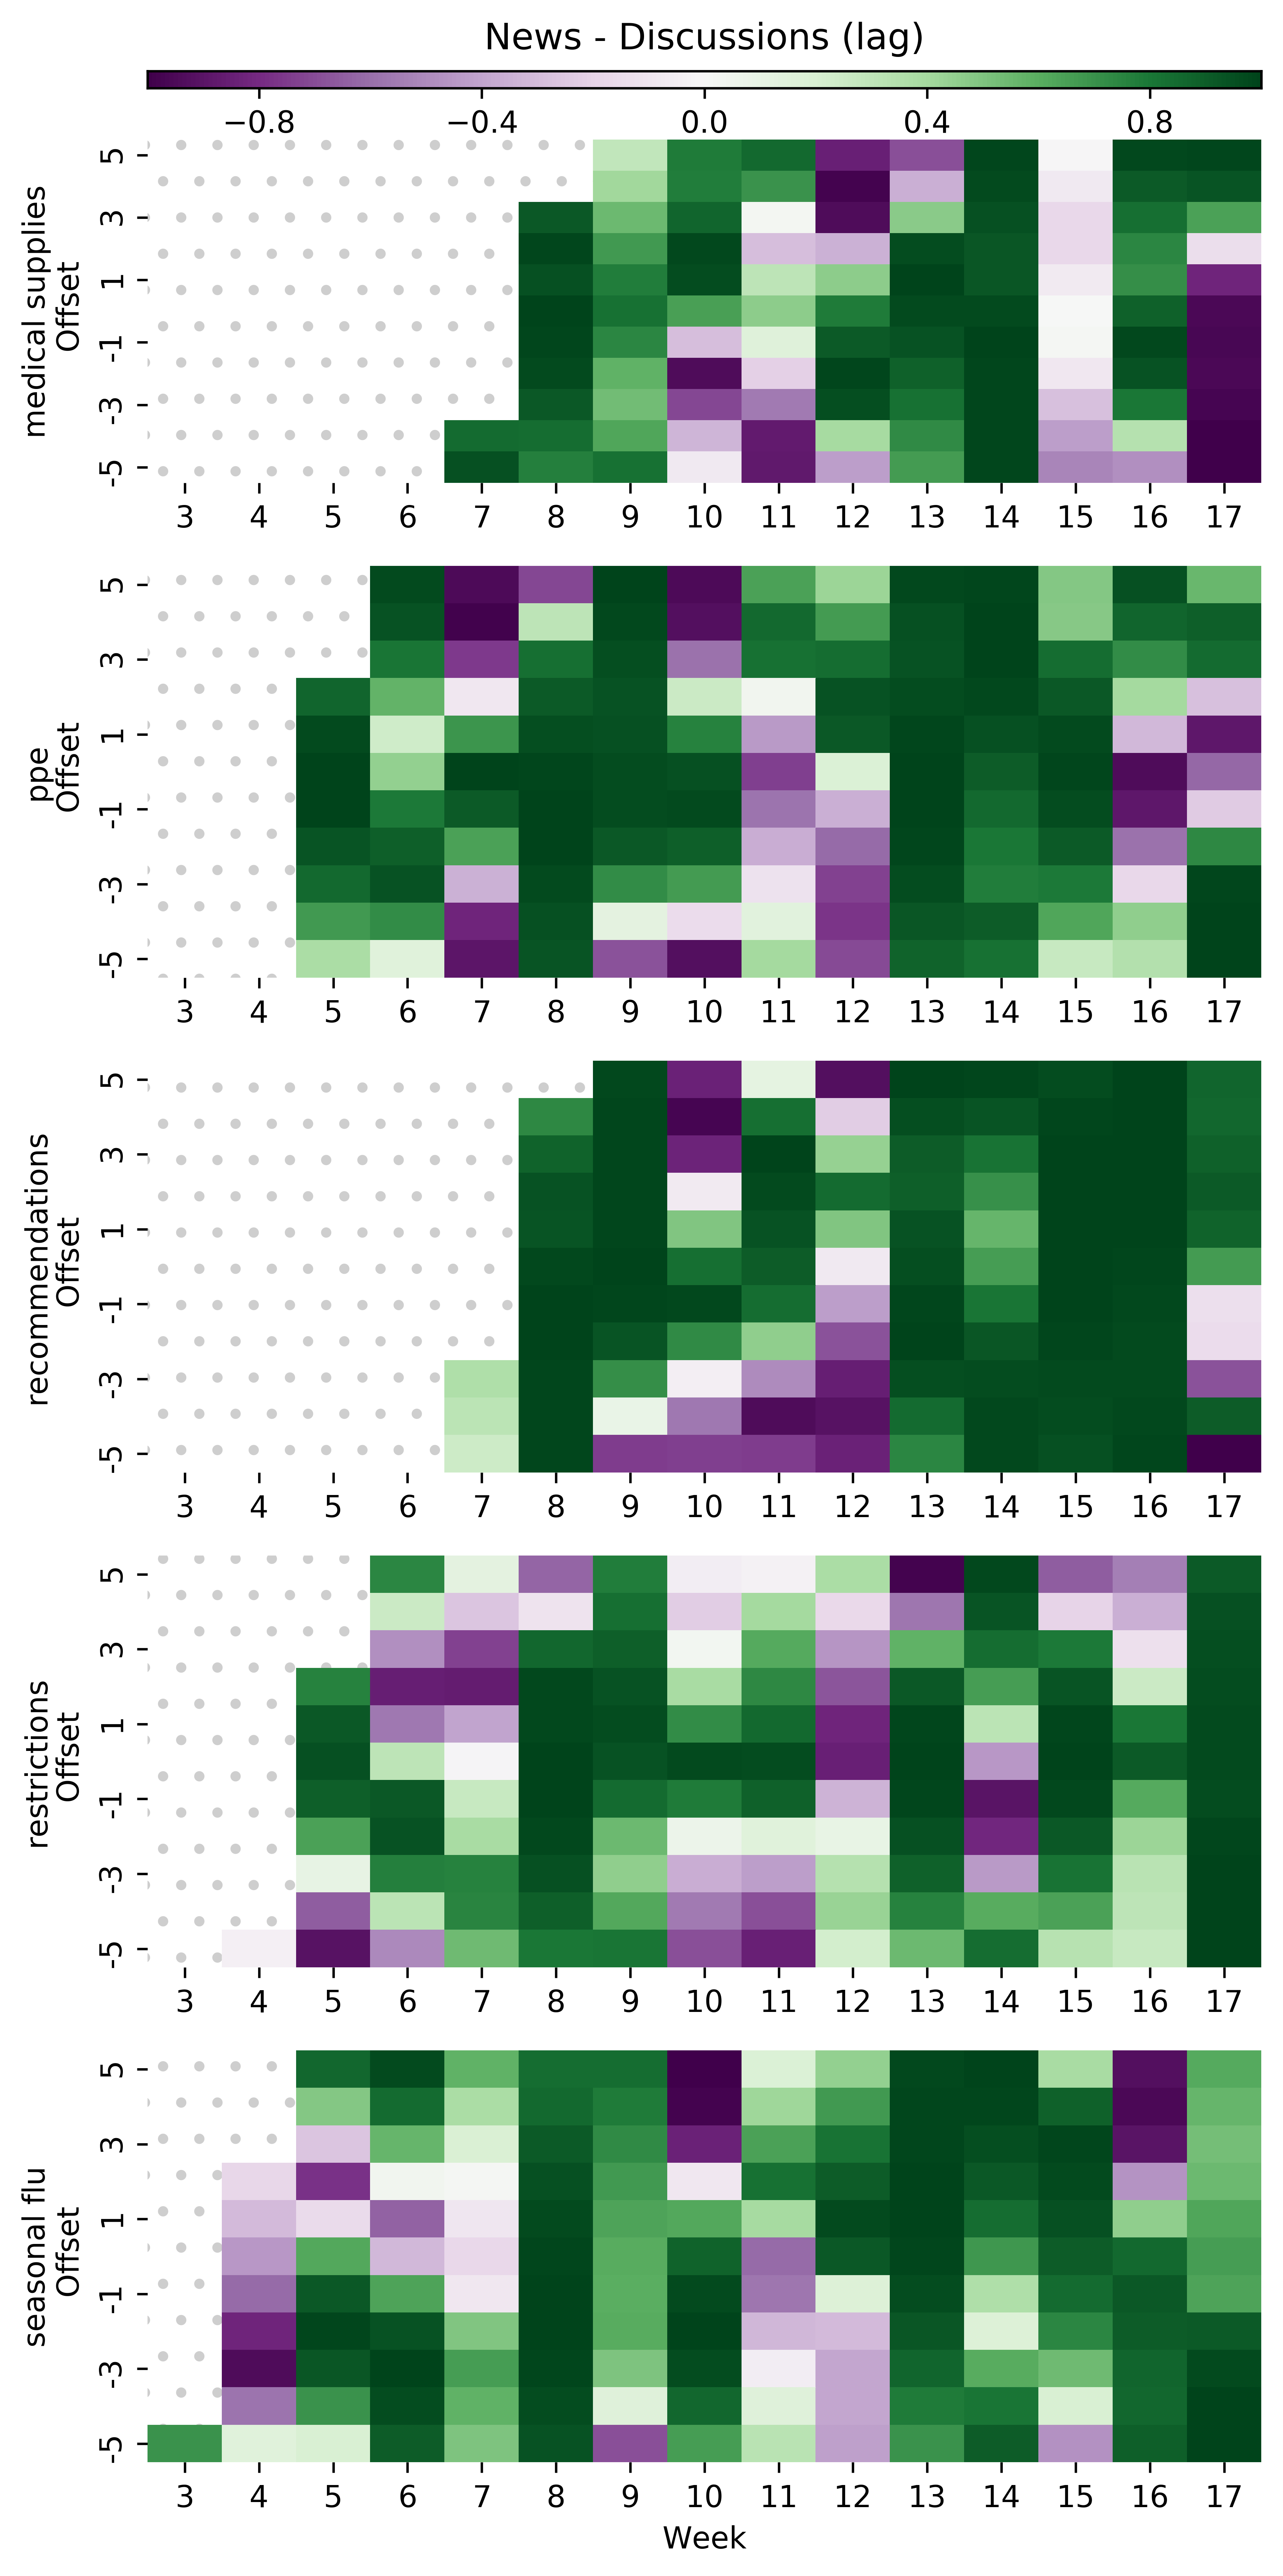

In [9]:
# plot heatmap of offsets between two platforms
figure, ax = plt.subplots(figsize=(6,12), sharex=True, sharey=True, dpi=600)
x = 1
week_max_index,week_max_value = [],[]
for g in themes:
    y = 0
    ax = plt.subplot(5, 1, x+y)
    step = 7
    start = 0
    end = step
    
    wtlcc,max_index,max_value = [],[],[]
    while end < len(dates):
        c_wtlcc = comp_wtlcc(platform_daily_volume,start,end,('news','discussions'),g)  
        wtlcc.append(c_wtlcc[0])
        max_index.append(c_wtlcc[1])
        max_value.append(c_wtlcc[2])     
        
        start = end
        end += step
    
    week_max_index.append(max_index)
    week_max_value.append(max_value)
    wtlcc = pd.DataFrame(wtlcc).T
        
    sns.heatmap(wtlcc,cmap='PRGn',ax=ax,vmax=1,vmin=-1,alpha=1,cbar=False)
    ax.set_xlim(xmin=2,xmax=17)
    
    if x == 1:
        ax.set_title('News - Discussions (lag)', pad=30, size=12)
        ax_divider = make_axes_locatable(ax)
        cax = ax_divider.append_axes('top', size = '5%', pad = '15%')
        colorbar(ax.get_children()[0], cax = cax, orientation = 'horizontal')
        cax.xaxis.set_ticks_position('bottom')
    if x == 5:
        ax.set(xlabel='Week')
    if y == 0:
        ax.set(ylabel='{}\n Offset'.format(g))
    ax.set_yticklabels(range(5,-6,-2))    
    ax.set_xticklabels(range(1,18))
    ax.patch.set(hatch='.', edgecolor='#cecece')
    x+=1
    
plt.tight_layout()
plt.savefig('wtlcc_themes_heatmap.jpg')

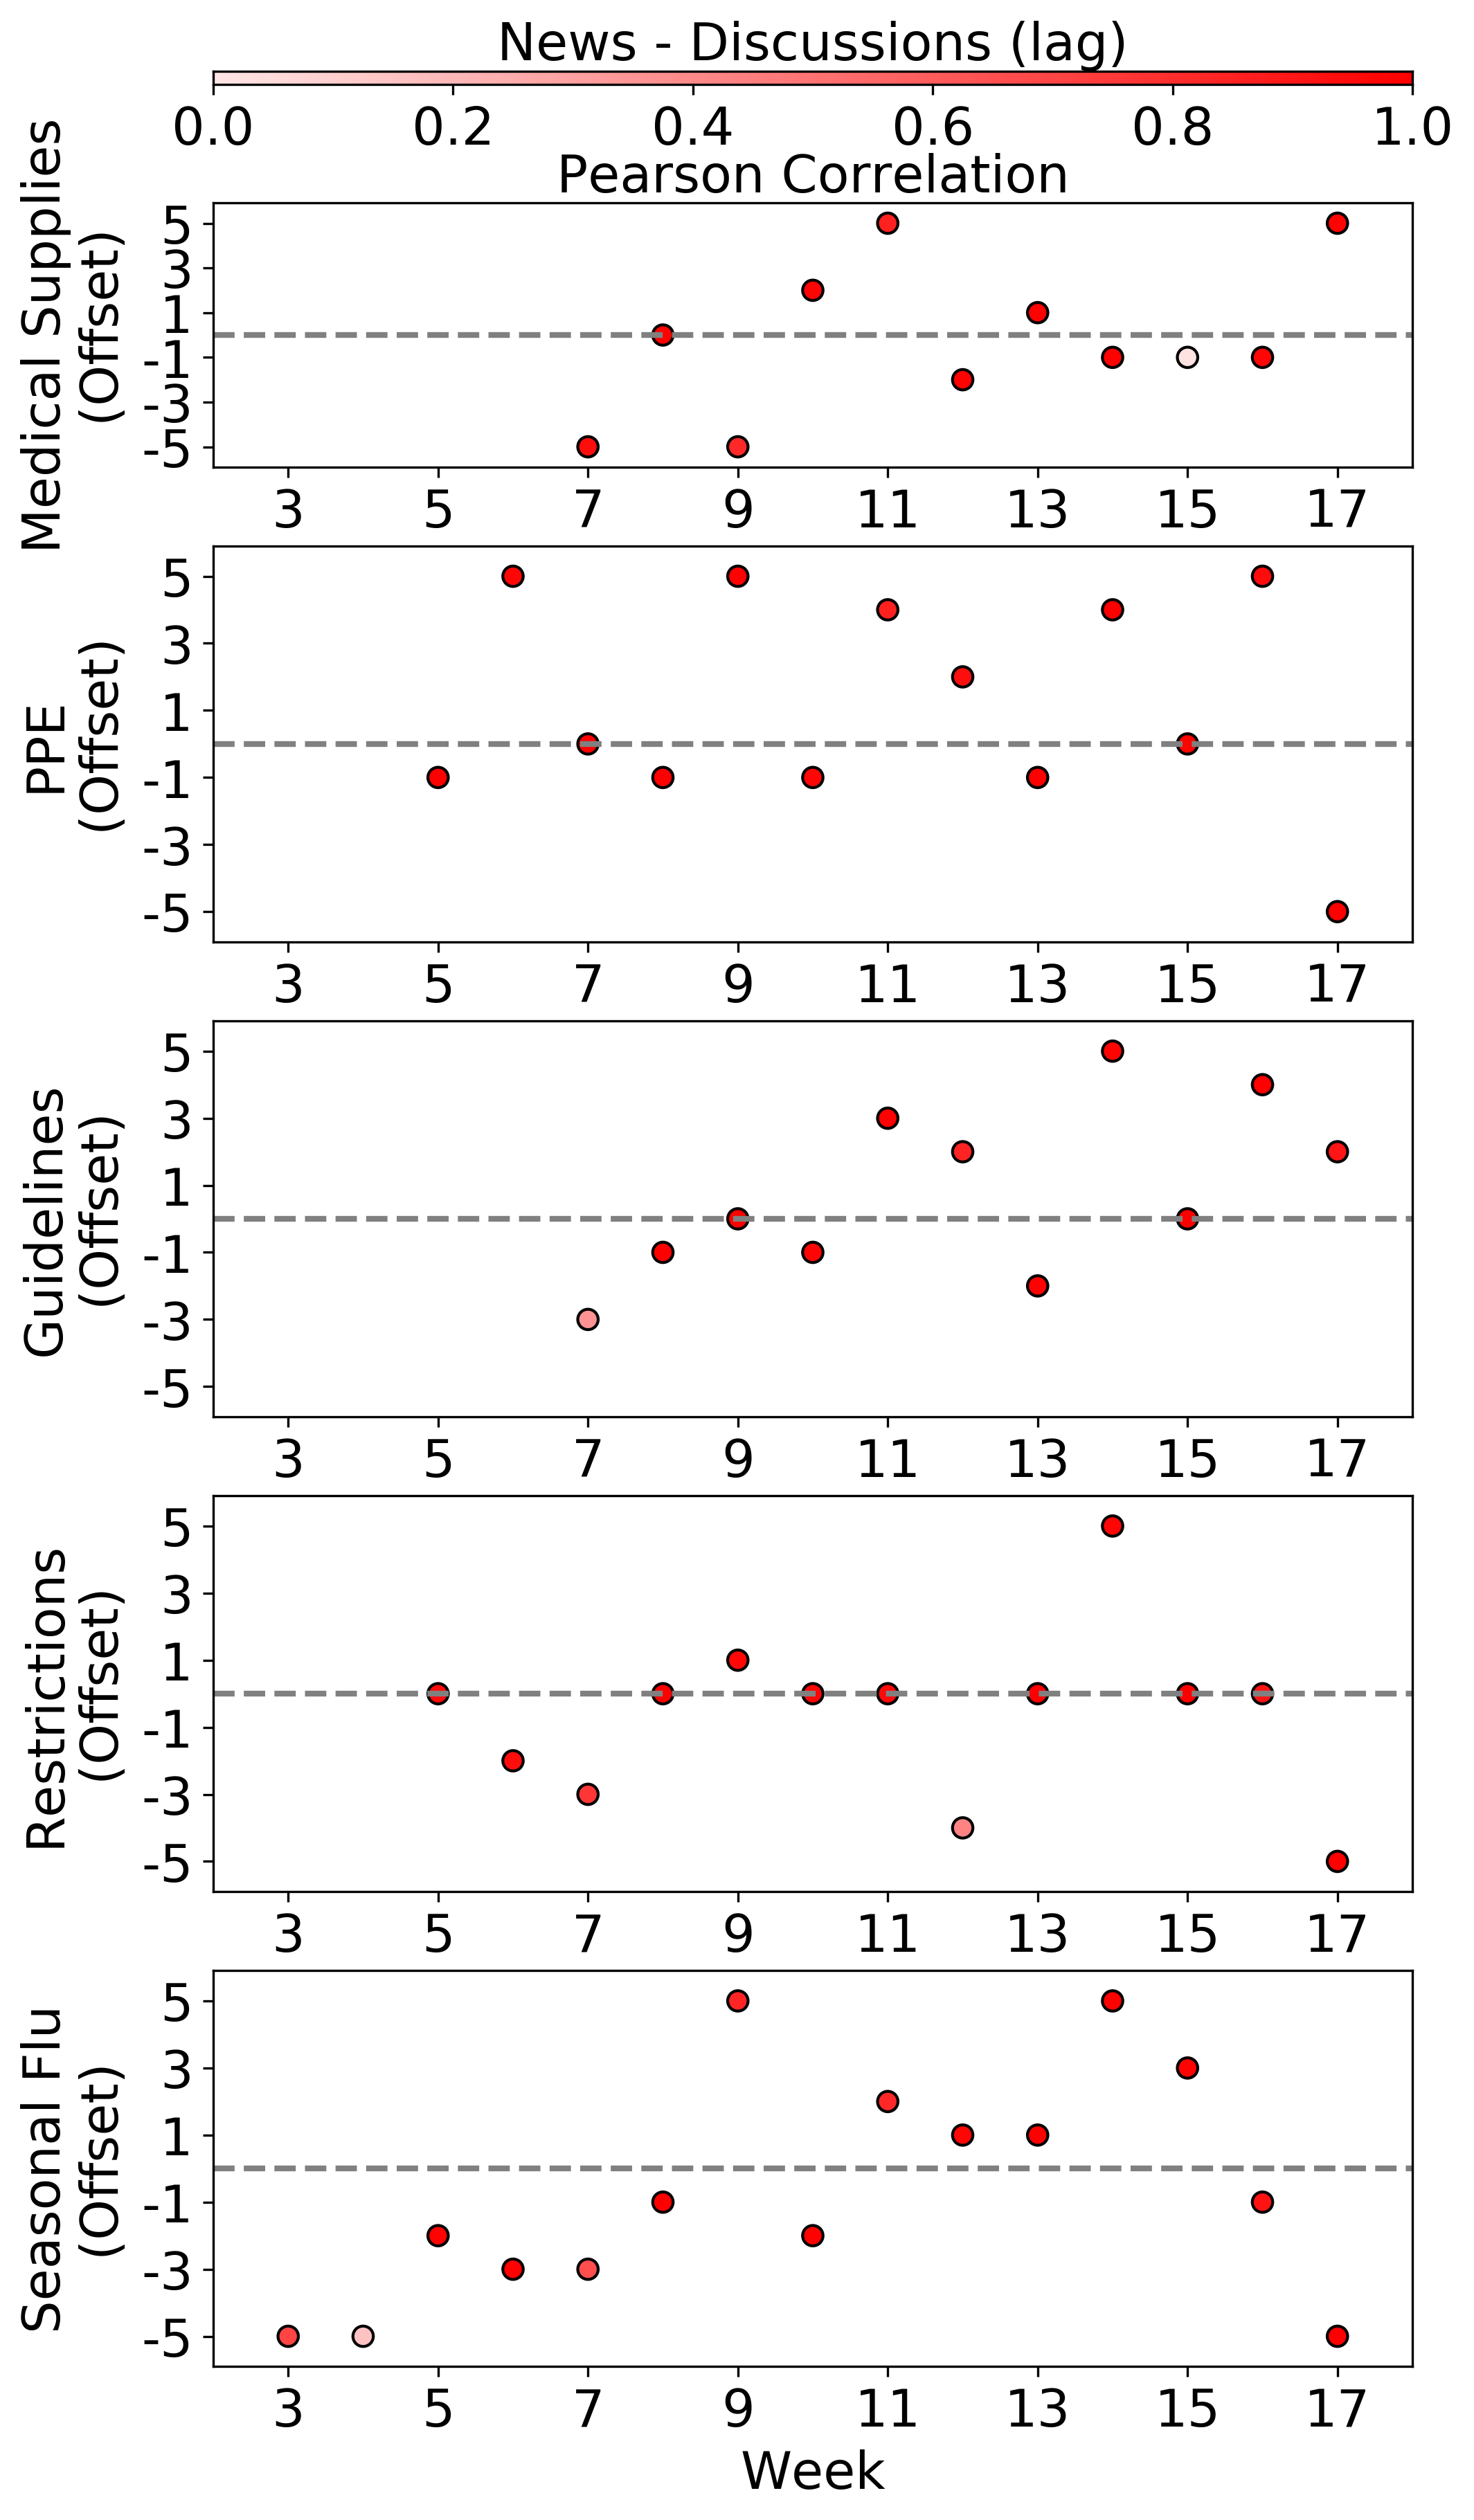

In [10]:
# plot scatter plot to show the best offset variation every week
figure, ax = plt.subplots(figsize=(7,12), sharex=True, sharey=True, dpi=300)
my_map = ListedColormap(sns.light_palette((1,0,0),10000))
x = 1
for g, mi, va in zip(groupings,week_max_index,week_max_value):
    y = 0
    ax = plt.subplot(5, 1, x+y)
    plt.sca(ax)
    sc = plt.scatter(np.array(range(len(mi))), mi, c=va, vmin=0, vmax=1, s=50, edgecolors='black', cmap=my_map)
    ax.set_xlim(xmin=1,xmax=17)
    ax.set_ylim(ymin=-5.9,ymax=5.9)
    ax.axhline(0, color='gray', lw=2, linestyle = '--')
    
    if x == 1:
        ax.set_title('Pearson Correlation', pad=0, size=18)
        ax_divider = make_axes_locatable(ax)
        cax = ax_divider.append_axes('top', size = '5%',pad = '45%')
        colorbar(ax.get_children()[0], cax = cax, orientation = 'horizontal')
        cax.xaxis.set_tick_params(labelsize=18)
        cax.xaxis.set_ticks_position('bottom')
        cax.xaxis.set_label_text('News - Discussions (lag)',size=18)
        cax.xaxis.set_label_position('top')
    if x == 5:
        ax.set_xlabel('Week',fontsize=18)
    if y == 0:
        ax.set_ylabel('{}\n (Offset)'.format(g),fontsize=18)

    ax.set_xticklabels(range(1,18,2), fontsize=18) 
    ax.set_yticks(np.arange(-5,6,2)) 
    ax.set_yticklabels(np.arange(-5,6,2), fontsize=18)
    x+=1

plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
plt.savefig('corr_themes_scatter.jpg',bbox_inches = 'tight')

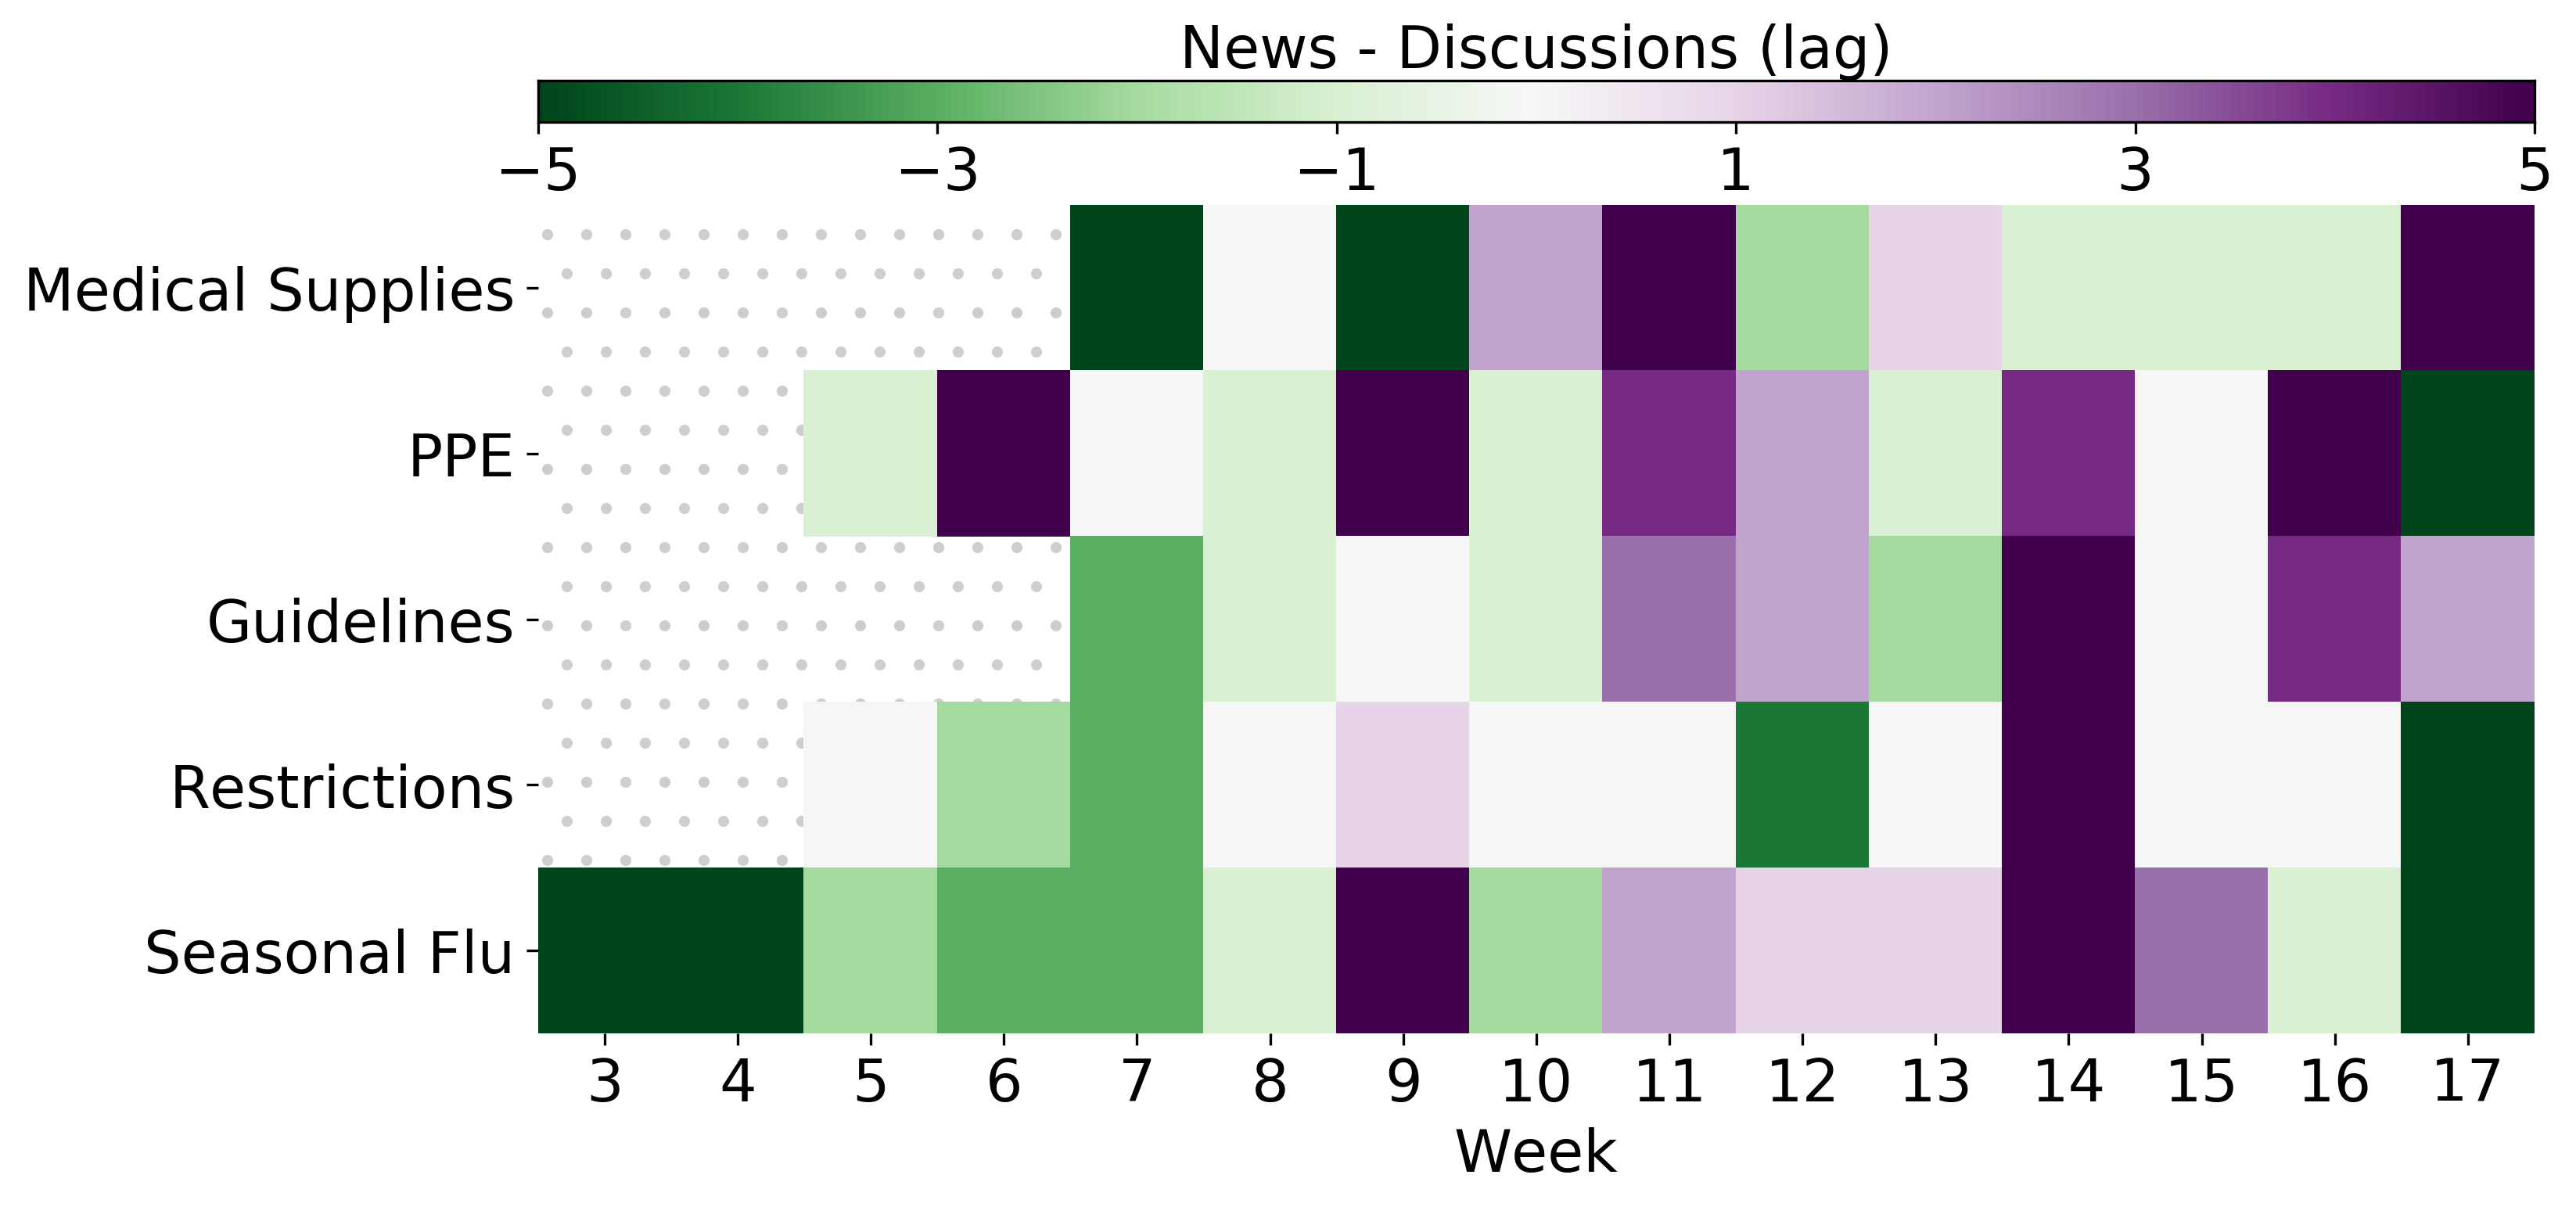

In [11]:
# plot a ensemble heatmap to show the best offset variation every week
figure, ax = plt.subplots(figsize=(11,5), sharex=True, sharey=True, dpi=300)

max_value_heat = pd.DataFrame(week_max_index)

sns.heatmap(max_value_heat,cmap='PRGn_r',ax=ax,vmax=5,vmin=-5,alpha=1,cbar=False)

ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes('top', size = '5%', pad = '10%')
colorbar(ax.get_children()[0], cax = cax, orientation = 'horizontal', ticks=[-5,-3,-1,1,3,5])
cax.xaxis.set_tick_params(labelsize=18)
cax.xaxis.set_ticks_position('bottom')
cax.xaxis.set_label_text('News - Discussions (lag)',size=18)
cax.xaxis.set_label_position('top')

ax.set_xlim(xmin=2,xmax=17)
ax.set_xlabel('Week',fontsize=18)
ax.patch.set(hatch='.', edgecolor='#cecece')

ax.set_xticklabels(range(1,18),fontsize=18)    
ax.set_yticklabels(list(groupings.keys()),rotation=0,fontsize=18)

plt.tight_layout()
plt.savefig('corr_heatmap.jpg',bbox_inches = 'tight')

In [12]:
n_leading_sum,d_leading_sum,tie_sum,total_sum=0,0,0,0
print('Time Delay in weeks:')
print('Theme / news_leading_ratio(times) / disc_leading_ratio(times) / tie_ratio(times)')
for i in range(len(themes)):
    A = np.array(week_max_index[i])
    n_leading = A[A<0]
    d_leading = A[A>0]
    tie = A[A==0]
    total = len(n_leading)+len(d_leading)+len(tie)
    
    n_leading_sum+=len(n_leading)
    d_leading_sum+=len(d_leading)
    tie_sum+=len(tie)
    total_sum+=total
    print('%s / %.3f(%d) / %.3f(%d) / %.3f(%d)' % (list(groupings.keys())[i],len(n_leading)/total,len(n_leading),len(d_leading)/total,len(d_leading),len(tie)/total,len(tie)))
    
print('%s / %.3f(%d) / %.3f(%d) / %.3f(%d)' % ('Overall',n_leading_sum/total_sum,n_leading_sum,d_leading_sum/total_sum,d_leading_sum,tie_sum/total_sum,tie_sum))

Time Delay in weeks:
Theme / news_leading_ratio(times) / disc_leading_ratio(times) / tie_ratio(times)
Medical Supplies / 0.545(6) / 0.364(4) / 0.091(1)
PPE / 0.385(5) / 0.462(6) / 0.154(2)
Guidelines / 0.364(4) / 0.455(5) / 0.182(2)
Restrictions / 0.308(4) / 0.154(2) / 0.538(7)
Seasonal Flu / 0.600(9) / 0.400(6) / 0.000(0)
Overall / 0.444(28) / 0.365(23) / 0.190(12)


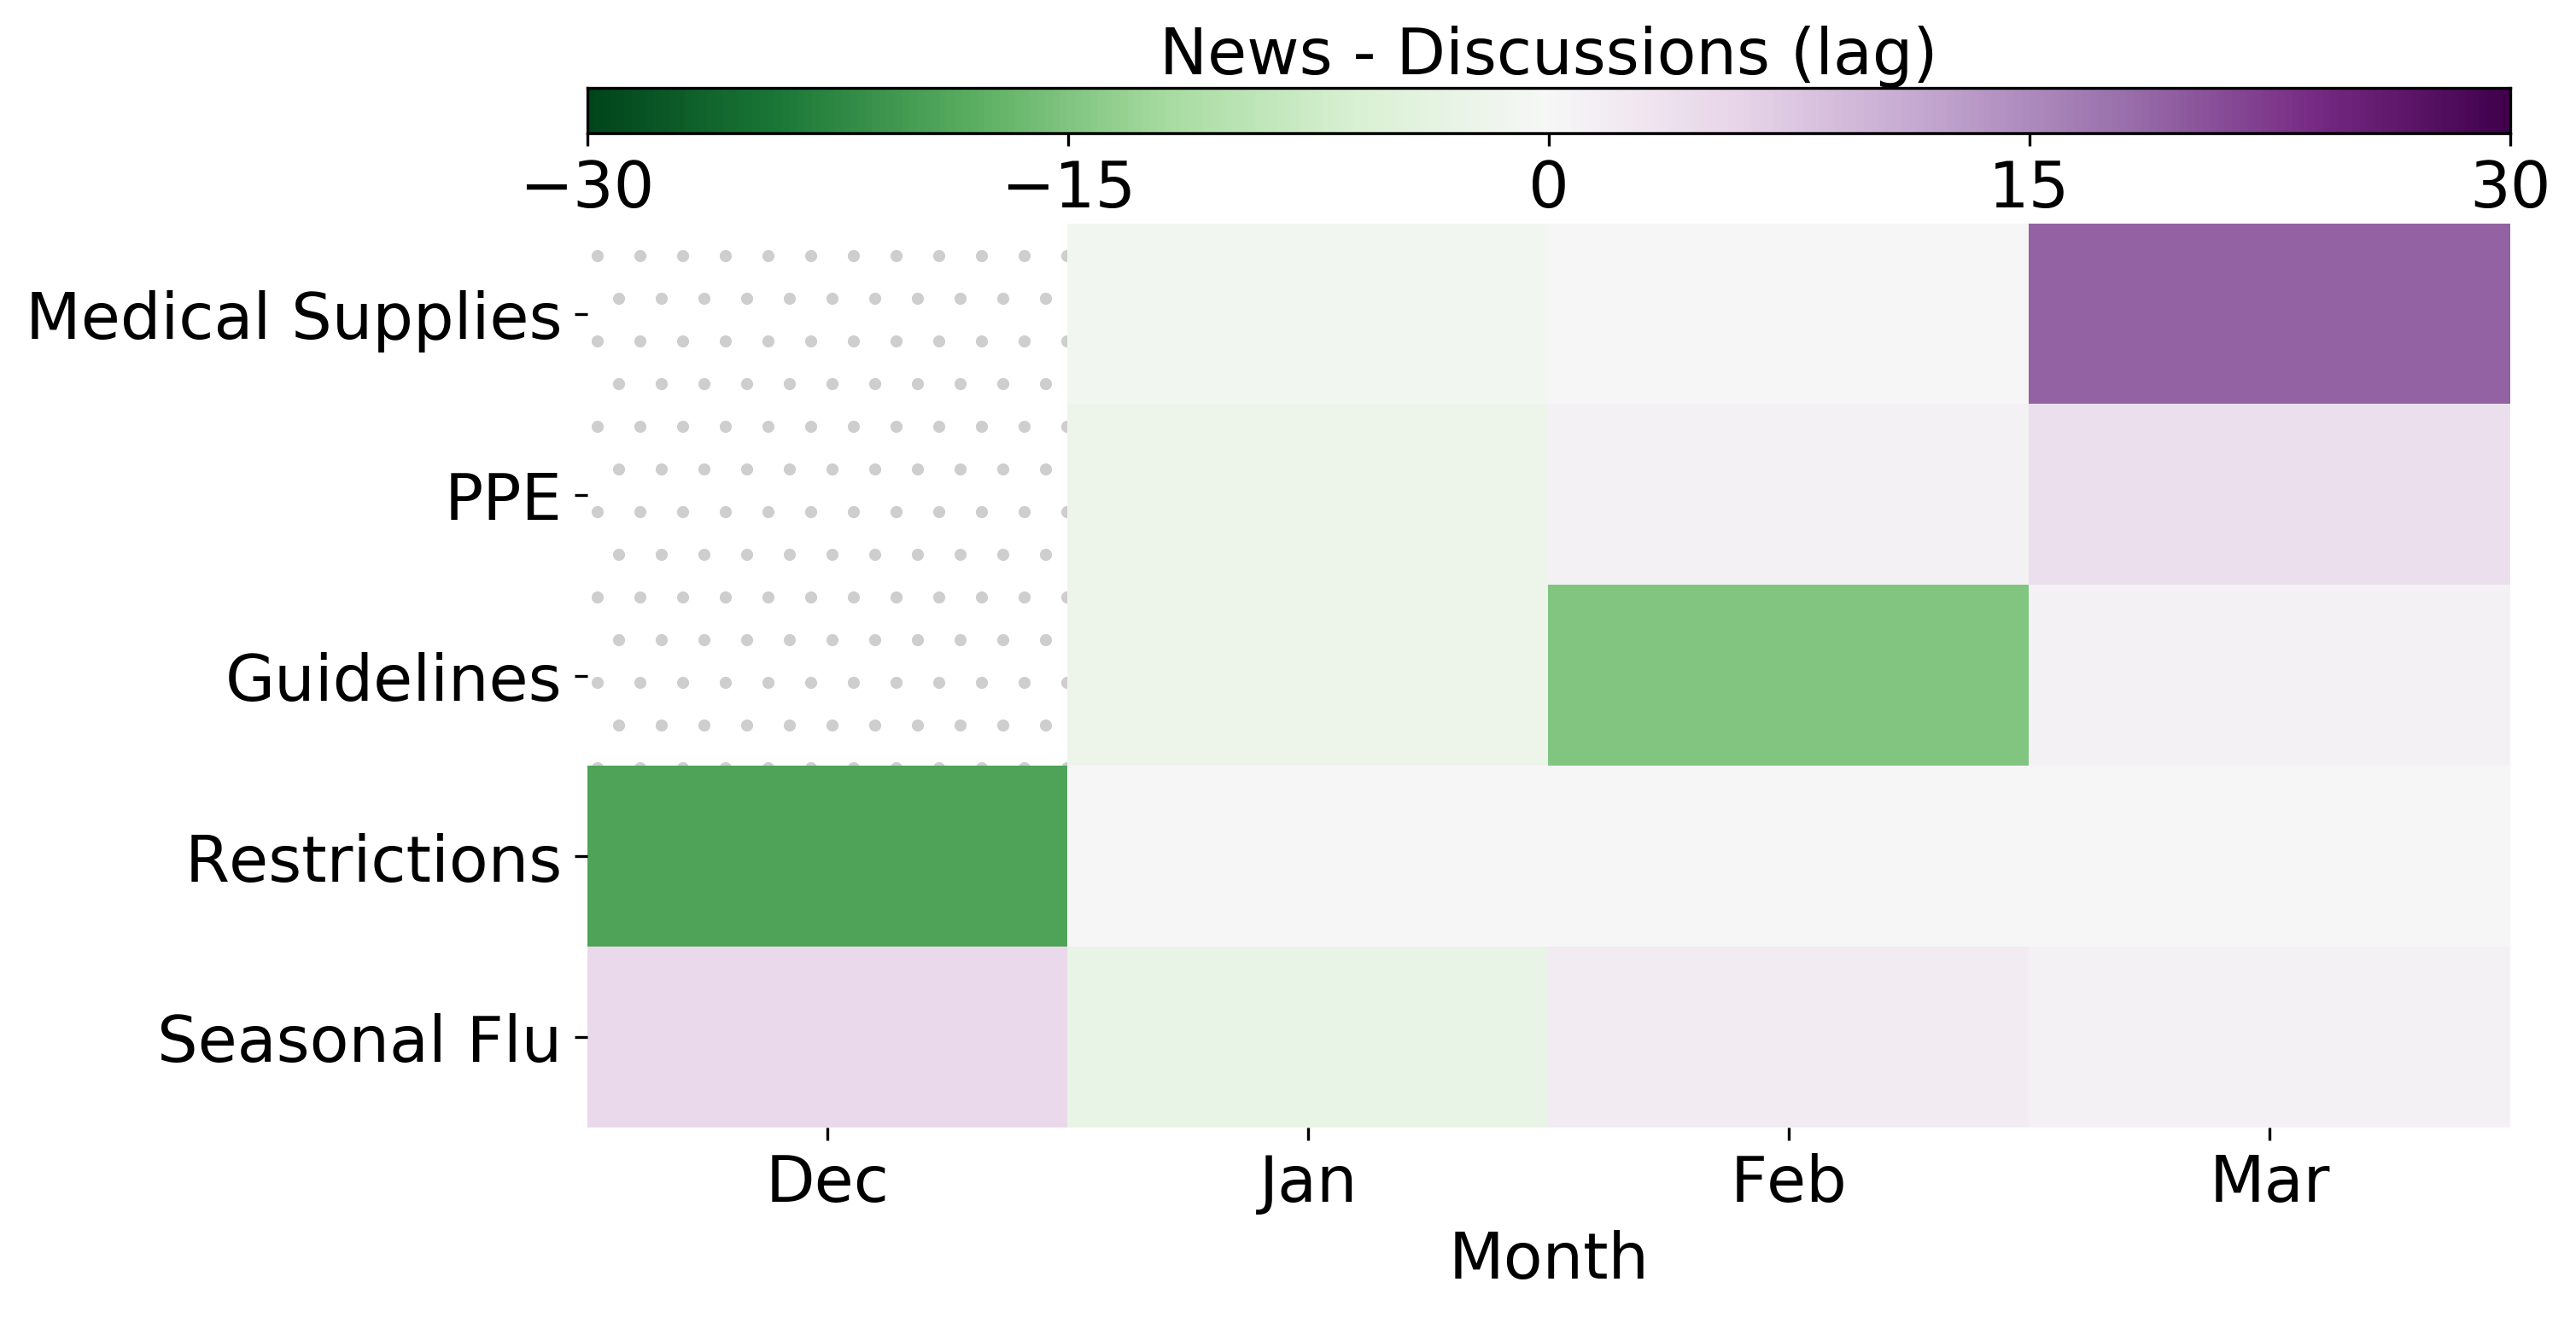

In [13]:
# plot a ensemble heatmap to show the best offset variation every month
figure, ax = plt.subplots(figsize=(10,5), sharex=True, sharey=True, dpi=300)

theme_month=[]
for t in themes:
    theme_month_max=[]
    for m in months:     
        start,end = months[m][0],months[m][1]
        c_wtlcc = comp_wtlcc(platform_daily_volume,start,end,('news','discussions'),t,30)
        theme_month_max.append(c_wtlcc[1])
    theme_month.append(theme_month_max)
    
max_value_heat = pd.DataFrame(theme_month)

sns.heatmap(max_value_heat,cmap='PRGn_r',ax=ax,vmax=30,vmin=-30,alpha=1,cbar=False)

ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes('top', size = '5%', pad = '10%')
colorbar(ax.get_children()[0], cax = cax, orientation = 'horizontal')
cax.xaxis.set_tick_params(labelsize=18)
cax.xaxis.set_ticks_position('bottom')
cax.xaxis.set_label_text('News - Discussions (lag)',size=18)
cax.xaxis.set_label_position('top')

ax.set_xlabel('Month',fontsize=18)
ax.patch.set(hatch='.', edgecolor='#cecece')

ax.set_xticklabels(['Dec','Jan','Feb','Mar'],fontsize=18)    
ax.set_yticklabels(list(groupings.keys()),rotation=0,fontsize=18)

plt.tight_layout()
plt.savefig('corr_heatmap_month.jpg',bbox_inches = 'tight')

In [14]:
n_leading_sum,d_leading_sum,tie_sum,total_sum=0,0,0,0
print('Time Delay in months:')
print('Theme / news_leading_ratio(times) / disc_leading_ratio(times) / tie_ratio(times)')
for i in range(len(themes)):
    A = np.array(theme_month[i])
    n_leading = A[A<0]
    d_leading = A[A>0]
    tie = A[A==0]
    total = len(n_leading)+len(d_leading)+len(tie)
    
    n_leading_sum+=len(n_leading)
    d_leading_sum+=len(d_leading)
    tie_sum+=len(tie)
    total_sum+=total
    print('%s / %.3f(%d) / %.3f(%d) / %.3f(%d)' % (list(groupings.keys())[i],len(n_leading)/total,len(n_leading),len(d_leading)/total,len(d_leading),len(tie)/total,len(tie)))
    
print('%s / %.3f(%d) / %.3f(%d) / %.3f(%d)'% ('Overall',n_leading_sum/total_sum,n_leading_sum,d_leading_sum/total_sum,d_leading_sum,tie_sum/total_sum,tie_sum))

Time Delay in months:
Theme / news_leading_ratio(times) / disc_leading_ratio(times) / tie_ratio(times)
Medical Supplies / 0.333(1) / 0.333(1) / 0.333(1)
PPE / 0.333(1) / 0.667(2) / 0.000(0)
Guidelines / 0.667(2) / 0.333(1) / 0.000(0)
Restrictions / 0.250(1) / 0.000(0) / 0.750(3)
Seasonal Flu / 0.250(1) / 0.750(3) / 0.000(0)
Overall / 0.353(6) / 0.412(7) / 0.235(4)
